In [16]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import copy
from torchvision import models
from sklearn.metrics import confusion_matrix,classification_report

In [17]:
import wandb

In [18]:
num_epochs = 20

In [19]:
wandb.init(
    # set the wandb entity where your project will be logged (generally your team name)
    entity="oleksii-oliinyk-lviv-polytechnic-national-university",

    # set the wandb project where this run will be logged
    project="eye-disease-classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "mobilenet",
    "dataset": "custom-eye-disease-dataset",
    "epochs": num_epochs,
    }
)

In [20]:
transform = transforms.Compose([
    transforms.Resize(640),
    transforms.RandomResizedCrop(size=640, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
])

In [21]:
dataset = datasets.ImageFolder(root="processed_dataset_final/training/", transform=transform)

val_dataset = datasets.ImageFolder(root="processed_dataset_final/validation/", transform=transform)


total_size = len(dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)


In [22]:
class_names = dataset.class_to_idx
num_classes = len(class_names)
num_classes

8

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
def model_train(model, optimizer, criterion, dataloader):
    model.train()
    actual = []
    predicted = []

    
    for batch in dataloader:
        images, labels = batch
        labels = labels.to(device)
        images = images.to(device)
        
        preds = model(images) 
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted_classes = torch.max(preds, 1)
        
        for label in labels.tolist(): actual.append(int(label))
        for predicted_class in predicted_classes.tolist(): predicted.append(int(predicted_class))
    
    actual = np.array(actual) 
    predicted = np.array(predicted)
    
    return actual, predicted

In [25]:
def model_eval(model,dataloader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            
            labels = labels.to(device)
            images = images.to(device)
            
            preds = model(images)
            #loss = criterion(preds, labels)
            
            _, predicted_classes = torch.max(preds, 1)
            
            for label in labels.tolist(): actual.append(int(label))
            for predicted_class in predicted_classes.tolist(): predicted.append(int(predicted_class)) 
        
    actual = np.array(actual) 
    predicted = np.array(predicted)
    
    return actual, predicted

In [26]:
def create_confusion_matrix(actual,predicted, epoch):
    
    cm = confusion_matrix(actual,predicted)
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['a_healthy_eye','cataract','dry_eye_syndrome','exopthalmos','jaundice','pterygium','stye','subcon_hemorrage'],
            yticklabels=['a_healthy_eye','cataract','dry_eye_syndrome','exopthalmos','jaundice','pterygium','stye','subcon_hemorrage'])
    plt.ylabel('Actual', fontsize=13)
    plt.title(f'Eval Confusion Matrix - Epoch #{epoch+1}', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [27]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [28]:
from torchvision.models import mobilenet_v3_large

In [29]:
model = mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.to(device)

d:\Programs\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programs\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [30]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # base lr is not critical, OneCycleLR overrides it

In [31]:
f = open("../logs/classification/classifier_training_mobilenet.txt", "w")

In [32]:
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=3e-3,  # Slightly lower than 1e-2, more stable for Adam
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% warmup
    div_factor=10,  # Initial LR = max_lr / 10
    final_div_factor=100,  # Final LR = max_lr / 100
    anneal_strategy='cos'  # Cosine annealing
)

Epoch #1 -> lr = 0.0002999999999999999
Training: 
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       324
           1       0.67      0.69      0.68       306
           2       0.70      0.54      0.61       205
           3       0.59      0.59      0.59        81
           4       0.68      0.55      0.60       179
           5       0.75      0.87      0.81       271
           6       0.57      0.66      0.61       265
           7       0.65      0.57      0.60       160

    accuracy                           0.67      1791
   macro avg       0.66      0.65      0.65      1791
weighted avg       0.67      0.67      0.66      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.79      0.43      0.56        35
           1       0.42      0.93      0.57        27
           2       0.67      0.50      0.57        20
           3       0.00      0.00      0.00        10
           4   

d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


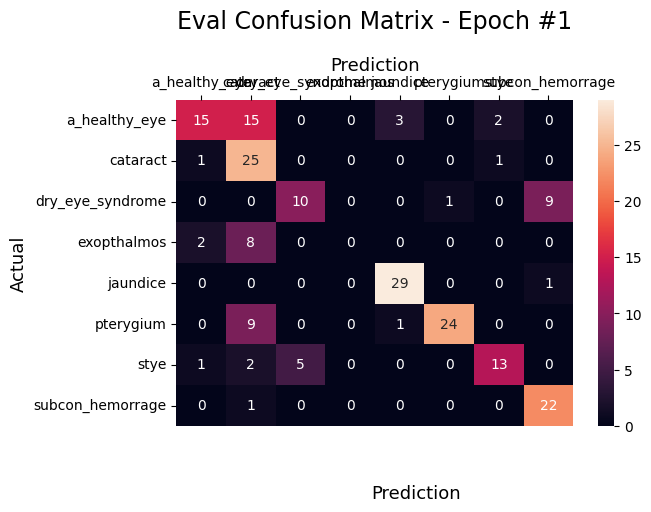

Current f1_score ->  0.6173242145042261
Epoch #2 -> lr = 0.00030002293109314187
Training: 
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       324
           1       0.92      0.93      0.93       306
           2       0.90      0.87      0.88       205
           3       0.88      0.85      0.87        81
           4       0.95      0.96      0.95       179
           5       0.97      0.97      0.97       271
           6       0.90      0.87      0.88       265
           7       0.91      0.93      0.92       160

    accuracy                           0.92      1791
   macro avg       0.92      0.91      0.92      1791
weighted avg       0.92      0.92      0.92      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        35
           1       0.57      0.93      0.70        27
           2       1.00      0.60      0.75        20
           3       1.00     

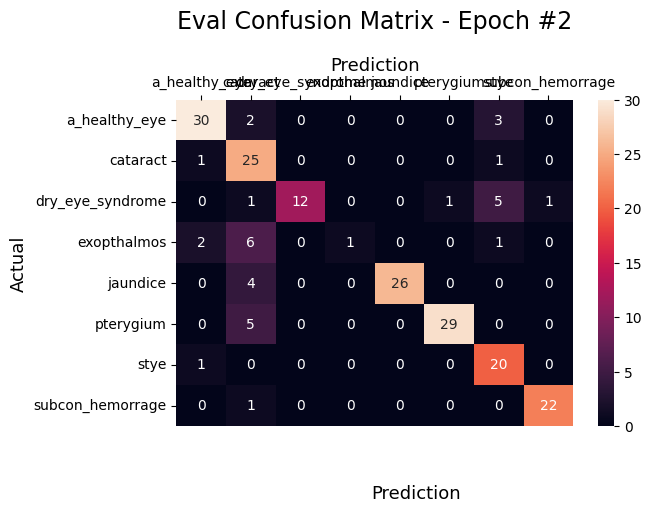

Current f1_score ->  0.7601582055642777
Epoch #3 -> lr = 0.000300091723593552
Training: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       324
           1       0.95      0.96      0.96       306
           2       0.94      0.96      0.95       205
           3       0.93      0.88      0.90        81
           4       0.99      0.99      0.99       179
           5       0.99      0.98      0.98       271
           6       0.97      0.98      0.98       265
           7       0.98      0.98      0.98       160

    accuracy                           0.97      1791
   macro avg       0.97      0.96      0.96      1791
weighted avg       0.97      0.97      0.97      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        35
           1       0.77      0.89      0.83        27
           2       1.00      0.80      0.89        20
           3       1.00      0

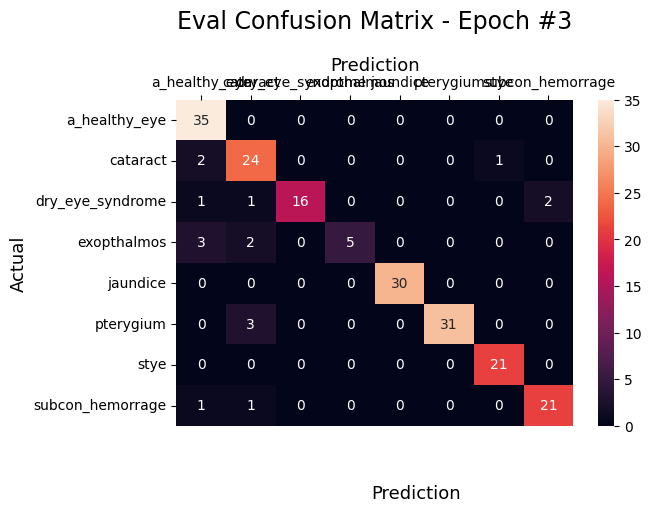

Current f1_score ->  0.891983311212069
Epoch #4 -> lr = 0.000300206375164213
Training: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       324
           1       0.97      0.97      0.97       306
           2       0.97      0.96      0.97       205
           3       0.96      0.96      0.96        81
           4       0.99      0.99      0.99       179
           5       0.99      0.99      0.99       271
           6       0.98      0.99      0.99       265
           7       0.96      0.95      0.96       160

    accuracy                           0.98      1791
   macro avg       0.98      0.98      0.98      1791
weighted avg       0.98      0.98      0.98      1791

Evaluation: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.93      0.96      0.95        27
           2       1.00      0.85      0.92        20
           3       1.00      1.

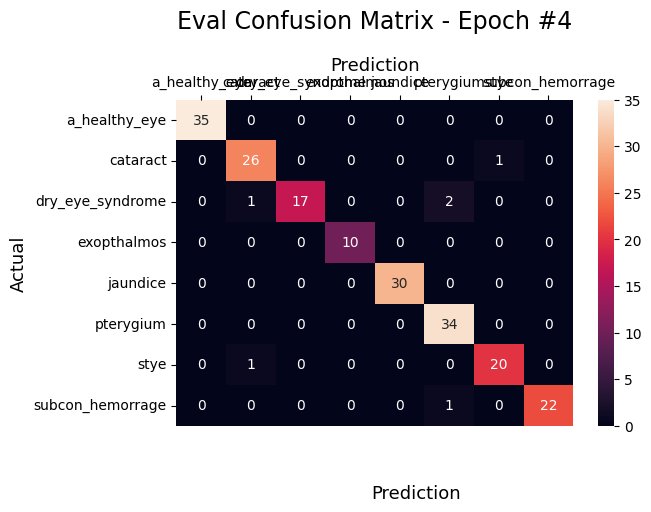

Current f1_score ->  0.9690348341756791
Epoch #5 -> lr = 0.00030036688191018273


KeyboardInterrupt: 

In [33]:
models_dict = []
best_eval_f1 = 0
patience = 4
patience_counter = 0

for i in range(num_epochs):
    
    current_lr = scheduler.get_last_lr()[0]
    
    epoch_message = f"Epoch #{i+1} -> lr = {current_lr}"
    print(epoch_message)
    f.write(epoch_message + "\n")
    
    train_actual, train_predicted = model_train(model, optimizer, criterion, train_loader)
    eval_actual, eval_predicted = model_eval(model, test_loader)
    
    train_report = classification_report(train_actual, train_predicted, output_dict=True)
    train_report_message = "Training: \n" + str(classification_report(train_actual, train_predicted, zero_division=0))
    print(train_report_message)
    f.write(train_report_message + "\n")
    
    eval_report = classification_report(eval_actual, eval_predicted, output_dict=True)
    eval_report_message = "Evaluation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
    print(eval_report_message)
    f.write(eval_report_message + "\n")
    
    wandb.log({
        "Train/Precision": train_report["macro avg"]['precision'], 
        "Train/Recall": train_report["macro avg"]['recall'],
        "Train/F1-Score": train_report["macro avg"]['f1-score'],
        "Train/Accuracy": train_report["accuracy"],
        
        "Eval/Precision": eval_report["macro avg"]['precision'], 
        "Eval/Recall": eval_report["macro avg"]['recall'],
        "Eval/F1-Score": eval_report["macro avg"]['f1-score'],
        "Eval/Accuracy": eval_report["accuracy"]
    })
    
    create_confusion_matrix(eval_actual, eval_predicted, i)
    
    models_dict.append(copy.deepcopy(model.state_dict()))
    if len(models_dict) > 4:
        models_dict.pop(0)
    
    eval_f1 = eval_report["macro avg"]['f1-score']
    print("Current f1_score -> ", eval_f1)
    
    if eval_f1 > best_eval_f1:
        best_eval_f1 = eval_f1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping on epoch #{i+1}")
            print("Loading best model from saved history.")
            model.load_state_dict(models_dict[0])
            break
    
    scheduler.step()

wandb.finish()   


Validation: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.93      0.96      0.95        27
           2       1.00      0.85      0.92        20
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        30
           5       0.92      1.00      0.96        34
           6       0.95      0.95      0.95        21
           7       1.00      0.96      0.98        23

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



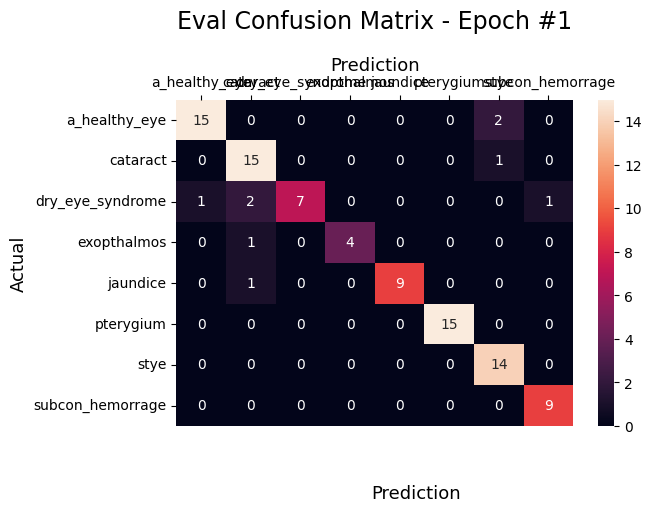

In [34]:
validation_actual, validation_predicted = model_eval(model, val_loader)

validation_report = classification_report(validation_actual, validation_predicted, output_dict=True)
validation_report_message = "Validation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
f.write(validation_report_message + "\n")
print(validation_report_message)
    
create_confusion_matrix(validation_actual, validation_predicted, 0)
f.close() 

In [ ]:
torch.save(model.state_dict(), "../models_info/classification_model_mobilenet.pth")